In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from xml.dom import minidom
from xml.etree.ElementTree import Element, SubElement, Comment
from xml.dom.minidom import Document

In [54]:
def read_species(image_path):
    image_path = image_path.removeprefix("test_direct/")
    end = None
    index = image_path.index("-")
    end_string = image_path[index:end]
    image_path = image_path.removesuffix(end_string)
    species = image_path.replace("_", " ")
    return species

def small_clusters(mask, area_size): 

    nlabel, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # delete smaller clusters that are less than 30 pixels in both height and width
    for i in range(nlabel):
        if (stats[i, cv2.CC_STAT_WIDTH] <= area_size) or (stats[i, cv2.CC_STAT_HEIGHT] <= area_size):
            mask[labels == i] = 0

def larger_clusters(mask): 

    nlabel, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # delete larger clusters that are greater than 200 pixels in both height and width
    for i in range(nlabel):
        if (stats[i, cv2.CC_STAT_WIDTH] >= 250) or (stats[i, cv2.CC_STAT_HEIGHT] >= 250):
            mask[labels == i] = 0

def border_clusters(mask):

    height, width = mask.shape[:2]
    nlabel, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # delete clusters touching the edges of the image 
    for i in range(nlabel):

        WIDTH = stats[i, cv2.CC_STAT_WIDTH]
        HEIGHT = stats[i, cv2.CC_STAT_HEIGHT]

        TOP = stats[i, cv2.CC_STAT_TOP]
        LEFT = stats[i, cv2.CC_STAT_LEFT]

        Y = TOP + HEIGHT
        X = LEFT + WIDTH

        if (LEFT == 0):
            mask[labels == i] = 0
        elif (TOP == 0):
            mask[labels == i] = 0
        elif (X == width):
            mask[labels == i] = 0
        elif (Y == height):
            mask[labels == i] = 0
        else:
            continue

# for image_path in glob.iglob(os.path.join('test_direct', "*.jpg")):

def auto_box(image_path):

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,th1 = cv2.threshold(gray,135,255,cv2.THRESH_BINARY_INV)

    # applying image filters
    small_clusters(th1, 25)
    larger_clusters(th1)
    border_clusters(th1)

    # constructing the kernel 
    kernel1 = np.ones((3,3), np.uint8)
    kernel2 = np.ones((2,2), np.uint8)

    # erode + dilation chain 
    th2 = cv2.erode(th1, kernel2, iterations=1)
    th2 = cv2.dilate(th2, kernel2, iterations=1)

    small_clusters(th2, 20)

    contours, hierarchy = cv2.findContours(th2, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    targetRectangles = []

    # List to store all the bounding rectangles:
    contours_poly = [None] * len(contours)
    boundRect = []

    zero_bndbox = True 

    # loop through bounding boxes:
    for b, c in enumerate(contours):

        # find only outer contours
        if hierarchy[0][b][3] == -1:

            # Approximate the contour to a polygon:
            contours_poly = cv2.approxPolyDP(c, 3, True)
            # Convert the polygon to a bounding rectangle:
            boundRect = cv2.boundingRect(contours_poly)

            # bounding box dimensions
            rectX = boundRect[0]
            rectY = boundRect[1]
            rectWidth = boundRect[2]
            rectHeight = boundRect[3]

            rectArea = rectWidth * rectHeight

            # Calculate the aspect ratio:
            aspectRatio = rectWidth / rectHeight
            delta = abs(1.0 - aspectRatio)

            # Set the min threshold values to identify the
            # blob of interest:
            minArea = 30
            epsilon = 0.4

            # filter bndboxes for shape and size 
            if rectArea > minArea and delta < epsilon:

                bnd_box = []

                bnd_box.append(int(rectX))
                bnd_box.append(int(rectY))
                bnd_box.append(int(rectX+rectWidth))
                bnd_box.append(int(rectY+rectHeight))

                targetRectangles.append(bnd_box)

                zero_bndbox = False


    if zero_bndbox == False:

        file_name = image_path.removeprefix('test_direct/') 
        file_path = image_path

        img_height, img_width, img_depth = img.shape
        
        species = read_species(image_path)

        doc = Document()
        
        root = doc.createElement('annotation') 
        doc.appendChild(root)

        main1 = doc.createElement('filename')
        root.appendChild(main1)
        text = doc.createTextNode(file_name)
        main1.appendChild(text)

        main2 = doc.createElement('path')
        root.appendChild(main2)
        text = doc.createTextNode(file_path)
        main2.appendChild(text)

        main3 = doc.createElement('source')
        root.appendChild(main3)
        sub3 = doc.createElement('database')
        main3.appendChild(sub3)
        text = doc.createTextNode('Unkown')
        sub3.appendChild(text)

        main4 = doc.createElement('size')
        root.appendChild(main4)
        sub4_1 = doc.createElement('width')
        main4.appendChild(sub4_1)
        text = doc.createTextNode(str(img_width))
        sub4_1.appendChild(text)
        sub4_2 = doc.createElement('height')
        main4.appendChild(sub4_2)
        text = doc.createTextNode(str(img_height))
        sub4_2.appendChild(text)
        sub4_3 = doc.createElement('depth')
        main4.appendChild(sub4_3)
        text = doc.createTextNode(str(img_depth))
        sub4_3.appendChild(text)

        main5 = doc.createElement('segmented')
        root.appendChild(main5)
        text = doc.createTextNode('0')     

        main6 = doc.createElement('object')
        root.appendChild(main6)

        for bnd_array in targetRectangles:

            bnd_xmin = bnd_array[0]
            bnd_ymin = bnd_array[1]
            bnd_xmax = bnd_array[2]
            bnd_ymax = bnd_array[3]

            main6_1 = doc.createElement('name')
            main6.appendChild(main6_1)
            text = doc.createTextNode(species)
            main6_1.appendChild(text)

            main6_2 = doc.createElement('pose')
            main6.appendChild(main6_2)
            text = doc.createTextNode('Unspecified')
            main6_2.appendChild(text)

            main6_3 = doc.createElement('truncated')
            main6.appendChild(main6_3)
            text = doc.createTextNode('0')
            main6_3.appendChild(text)

            main6_4 = doc.createElement('difficult')
            main6.appendChild(main6_4)
            text = doc.createTextNode('0')
            main6_4.appendChild(text)


            main6_5 = doc.createElement('bndbox')
            main6.appendChild(main6_5)

            main6_5_1 = doc.createElement('xmin')
            main6_5.appendChild(main6_5_1)
            text = doc.createTextNode(str(bnd_xmin))
            main6_5_1.appendChild(text)

            main6_5_2 = doc.createElement('ymin')
            main6_5.appendChild(main6_5_2)
            text = doc.createTextNode(str(bnd_ymin))
            main6_5_2.appendChild(text)

            main6_5_3 = doc.createElement('xmax')
            main6_5.appendChild(main6_5_3)
            text = doc.createTextNode(str(bnd_xmax))
            main6_5_3.appendChild(text)

            main6_5_4 = doc.createElement('ymax')
            main6_5.appendChild(main6_5_4)
            text = doc.createTextNode(str(bnd_ymax))
            main6_5_4.appendChild(text)

                    
        xml_str = root.toprettyxml(indent ="\t") 

        
        if image_path.endswith('.jpg'):
            save_path_file = image_path.removesuffix('.jpg')
        elif image_path.endswith('.jpeg'):
            save_path_file = image_path.removesuffix('.jpeg')

        save_path_file = save_path_file + '.xml'
        
        with open(save_path_file, "w") as f:
            f.write(xml_str)           
                         


In [58]:
auto_box('Amblyomma_americanum-80735201.jpeg')

In [43]:
for image_path in glob.iglob('test_direct/*'):
    if image_path.endswith('.jpg') or image_path.endswith('.jpeg'):
        auto_box(image_path)

In [41]:
for file in glob.iglob('test_direct/*'):
    if file.endswith('.xml'):
        os.remove(file)


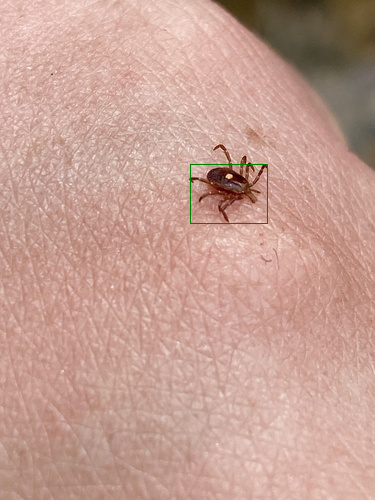

In [39]:
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw

xml_path = 'test_direct/79943330.xml'
image_path = xml_path.removesuffix(".xml") + '.jpg'
sample_image = Image.open(image_path) 
tree = ET.parse(xml_path)
root = tree.getroot()

sample_annotations = []

for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
    
#     print(xmin, ymin, xmax, ymax)
    sample_annotations.append([xmin, ymin, xmax, ymax])
    
sample_image_annotated = sample_image.copy()

img_bbox = ImageDraw.Draw(sample_image_annotated)

for bbox in sample_annotations:
    img_bbox.rectangle(bbox, outline="green") 

sample_image_annotated
